In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as to
import tensorflow as tf
import keras as kr
from keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import h5py

In [8]:
lead_order = ["DI", "DII", "DIII", "AVL", "AVF", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]
df_goldStandard = pd.read_csv('data/annotations/gold_standard.csv')
df_goldStandard['nb_abnormality'] =  df_goldStandard.sum(axis=1)

In [3]:
print(df_goldStandard.shape)
display(df_goldStandard.head(20).T)

(827, 7)


0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  \
1dAVb           0  0  0  0  0  0  0  0  0  0   0   0   1   0   0   1   0   0   
RBBB            0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
LBBB            0  1  0  0  0  0  0  0  0  0   0   0   0   0   0   1   0   0   
SB              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
AF              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
ST              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
nb_abnormality  0  1  0  0  0  0  0  0  0  0   0   0   1   0   0   2   0   0   

                18  19  
1dAVb            1   0  
RBBB             0   0  
LBBB             1   0  
SB               0   0  
AF               0   0  
ST               0   0  
nb_abnormality   2   0

In [11]:
print(df_goldStandard.shape)
display(df_goldStandard.head(20).T)
with h5py.File(f"data/ecg_tracings.hdf5", "r") as f:
  x = np.array(f['tracings'])
print(x.shape)

(827, 7)


0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  \
1dAVb           0  0  0  0  0  0  0  0  0  0   0   0   1   0   0   1   0   0   
RBBB            0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
LBBB            0  1  0  0  0  0  0  0  0  0   0   0   0   0   0   1   0   0   
SB              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
AF              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
ST              0  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   0   0   
nb_abnormality  0  1  0  0  0  0  0  0  0  0   0   0   1   0   0   2   0   0   

                18  19  
1dAVb            1   0  
RBBB             0   0  
LBBB             1   0  
SB               0   0  
AF               0   0  
ST               0   0  
nb_abnormality   2   0

(827, 4096, 12)


In [4]:
model = load_model(f"model/model.hdf5", compile=False)
model.compile(loss='binary_crossentropy', optimizer=Adam())

for layer in model.layers:
  print(layer.output_shape)
print(model.summary())


[(None, 4096, 12)]
(None, 4096, 64)
(None, 4096, 64)
(None, 4096, 64)
(None, 4096, 128)
(None, 4096, 128)
(None, 4096, 128)
(None, 4096, 128)
(None, 1024, 64)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 128)
(None, 1024, 196)
(None, 1024, 196)
(None, 1024, 196)
(None, 1024, 196)
(None, 256, 128)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 196)
(None, 256, 256)
(None, 256, 256)
(None, 256, 256)
(None, 256, 256)
(None, 64, 196)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 256)
(None, 64, 320)
(None, 64, 320)
(None, 64, 320)
(None, 64, 320)
(None, 16, 256)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 16, 320)
(None, 5120)
(None, 6)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape   

In [5]:
### gradcam
## grad cam part :

import tensorflow as tf
from keras import backend as k


def find_last_conv(model):
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 3:
      return layer.name


def grad_cam(model, time_serie, class_index, relative=True):
  '''
  version img :
  https://github.com/sicara/tf-explain/blob/master/tf_explain/core/grad_cam.py
  '''
  
  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(find_last_conv(model)).output, model.output])
  with tf.GradientTape() as tape:
    inputs = tf.cast([time_serie], tf.float32)
    conv_outputs, predictions = grad_model(inputs)
    loss = predictions[:, class_index]

  grads = tape.gradient(loss, conv_outputs)
  A = np.asarray(conv_outputs[0,:,:])
  dy = np.asarray(grads[0,:,:])
  a_k = dy.mean(axis=0)
  heat_map = np.sum(a_k*A, axis=1)
  heat_map = heat_map * (heat_map>0)
  
  if relative :
    heat_map /= heat_map.max()+1e-6
  return heat_map

 

In [6]:
from scipy.interpolate import interp1d

def plot_grad_cam_ecg(ts, check_y, selected_leads=True, relatives=True):
  hm = grad_cam(model, ts, check_y, relative=relatives)
  hm_interp = interp1d(np.linspace(0,10.24,16), hm, kind='slinear')
  if selected_leads:
    fig, axs = plt.subplots(1, 3,figsize=(40,5))
    for i,pos in enumerate([1,6,11]):
      ax = axs[i]
      ax.set_title(lead_order[pos],fontsize=10)
      ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
      t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
    fig.colorbar(t,ax=axs)
    plt.show()
    
  else :
    fig, axs = plt.subplots(4, 3,figsize=(20,16))
    for i in range(12):
      ax = axs[i//3, i%3]
      ax.set_title(lead_order[i],fontsize=10)
      ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
      t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
    fig.colorbar(t,ax=axs)
    plt.show()

1dAVb 0
RBBB 1
LBBB 2
SB 3
AF 4
ST 5


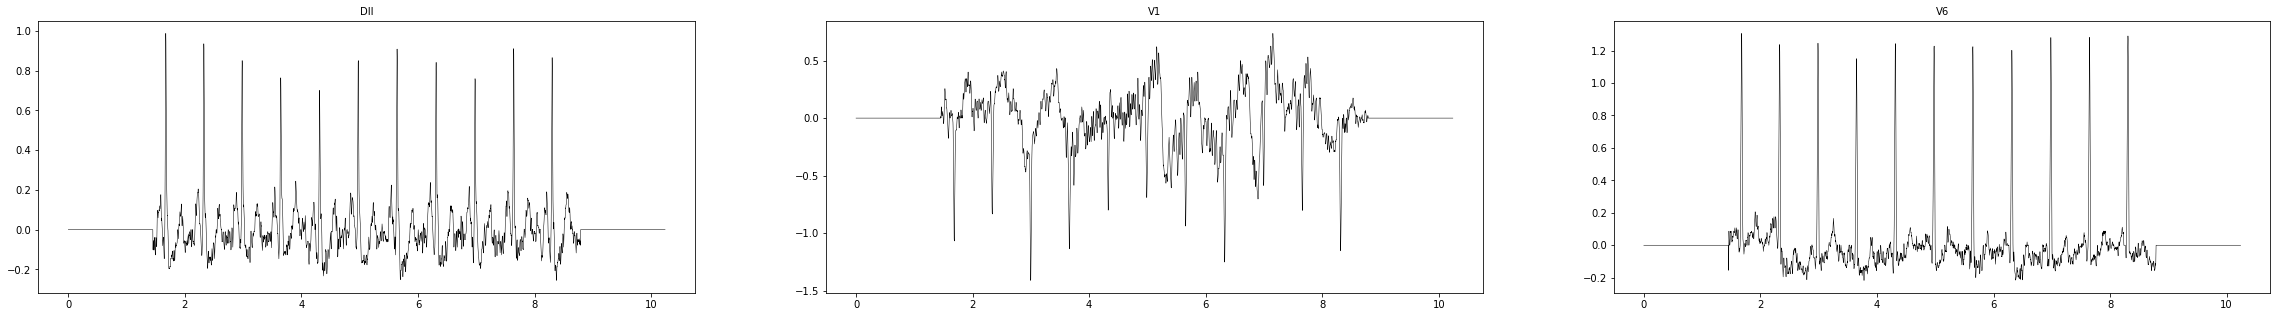

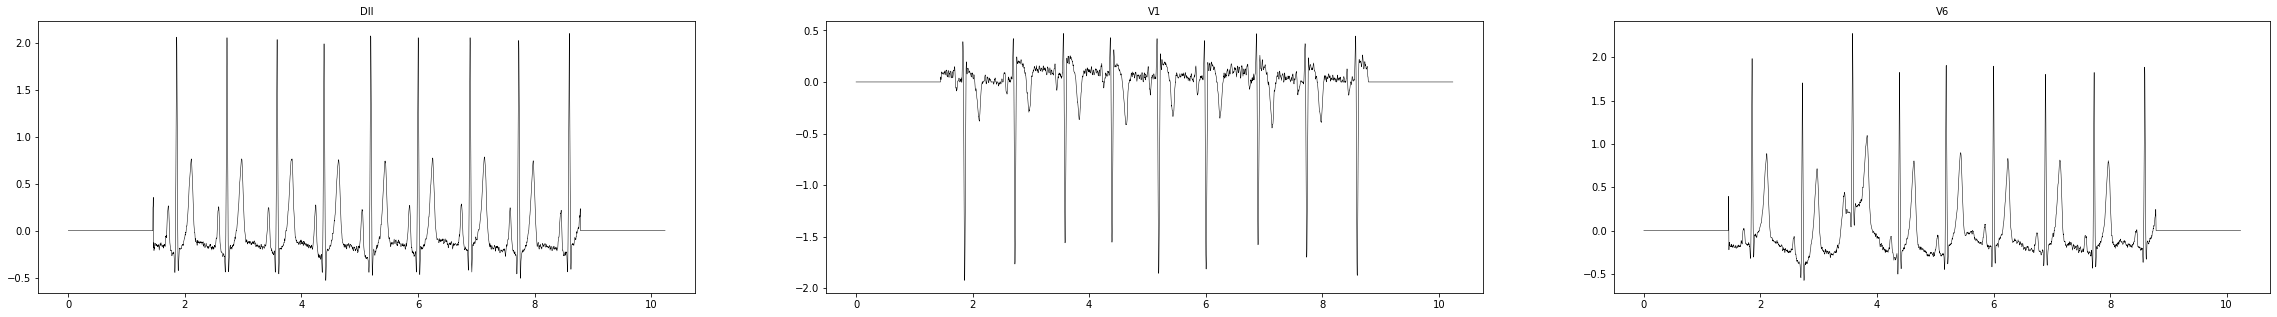

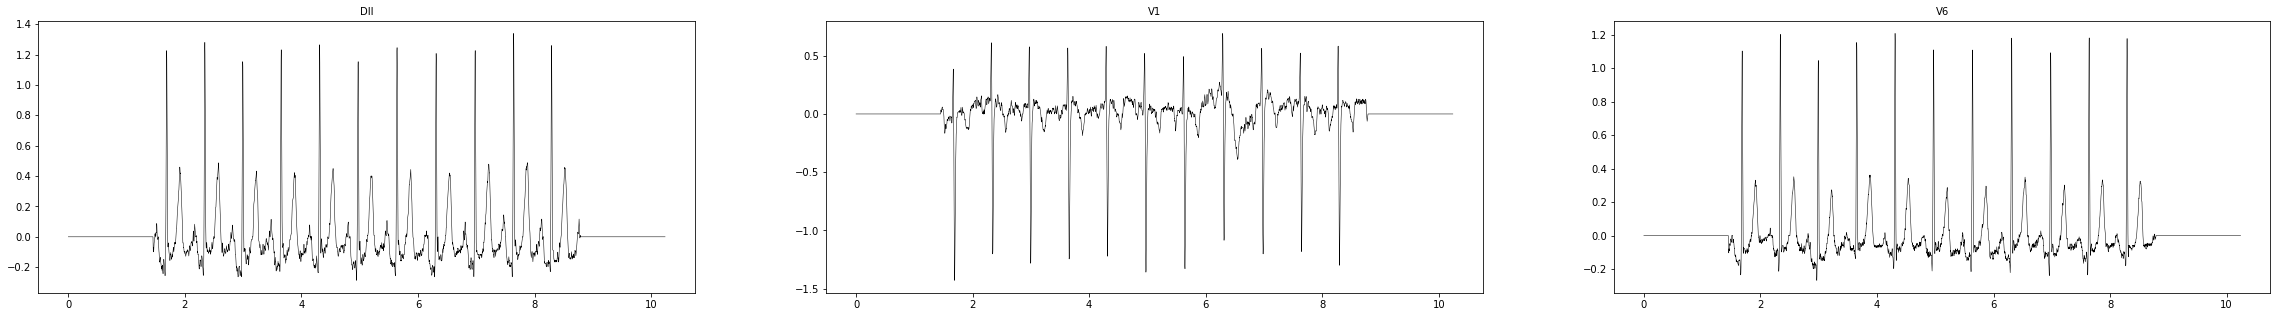



###########	 1dAVb	###########

1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 12, dtype: int64
[0.19 0.   0.   0.   0.   0.  ]


1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 32, dtype: int64
[0.16 0.   0.   0.   0.06 0.  ]


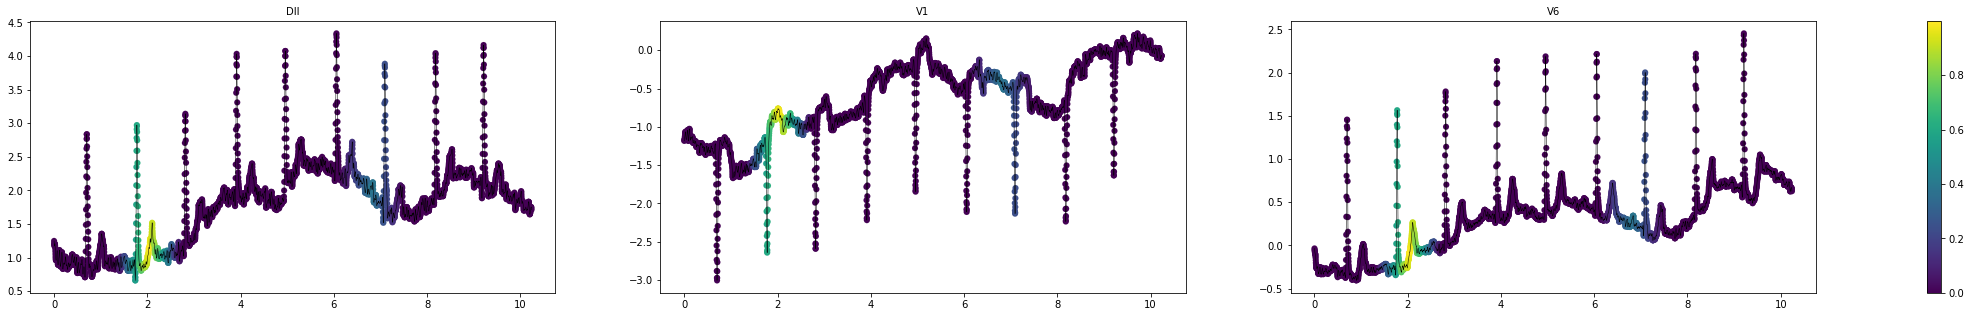

1dAVb             1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 57, dtype: int64
[0.06 0.   0.   0.   0.   0.  ]


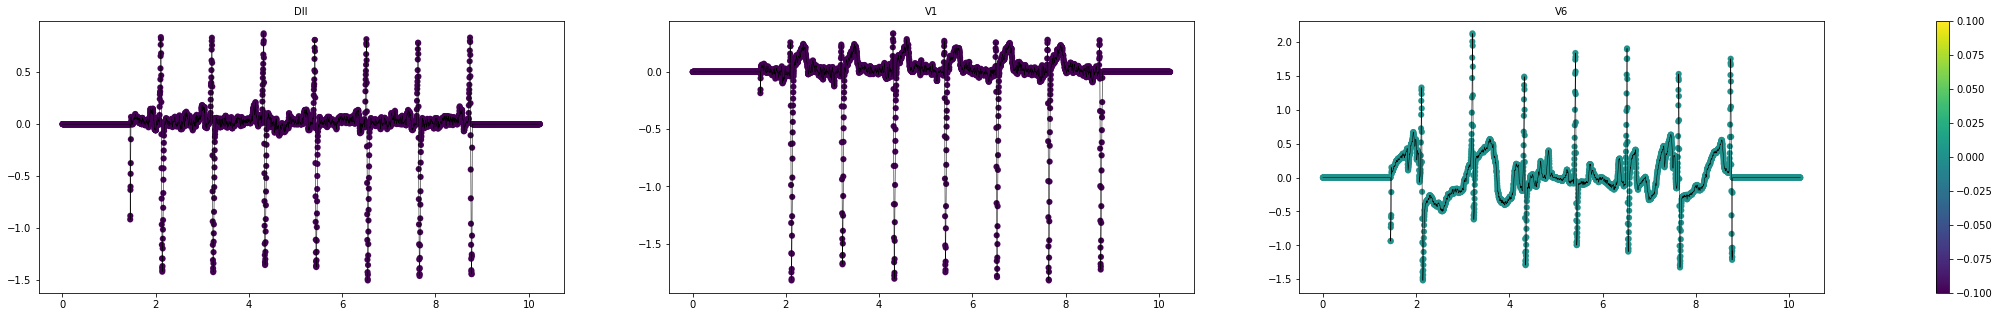



###########	 RBBB	###########

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 106, dtype: int64
[0.   0.79 0.   0.   0.   0.  ]


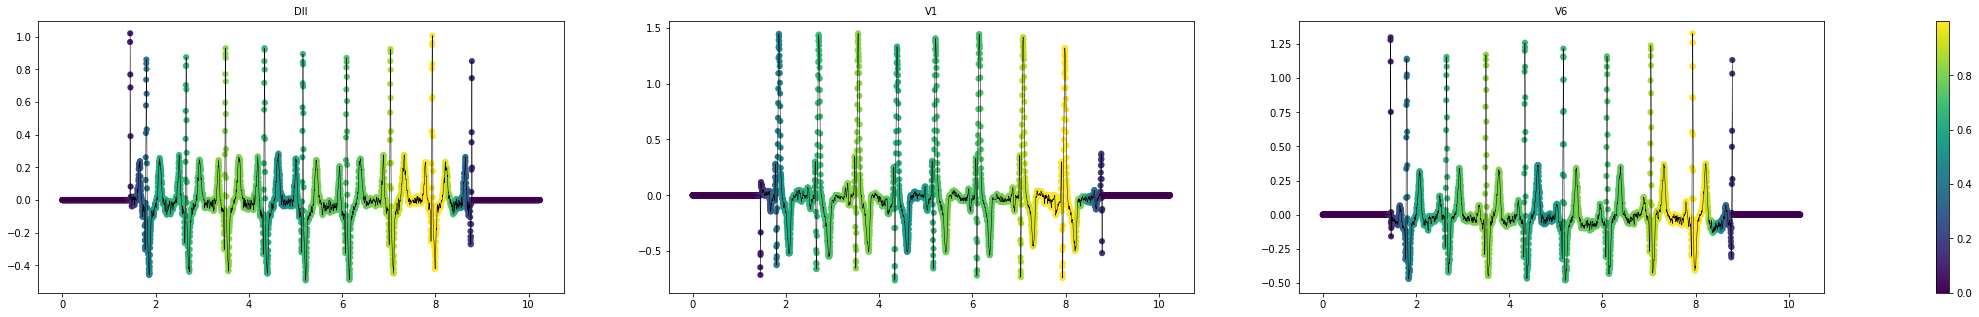

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 241, dtype: int64
[0.   0.43 0.   0.   0.   0.  ]


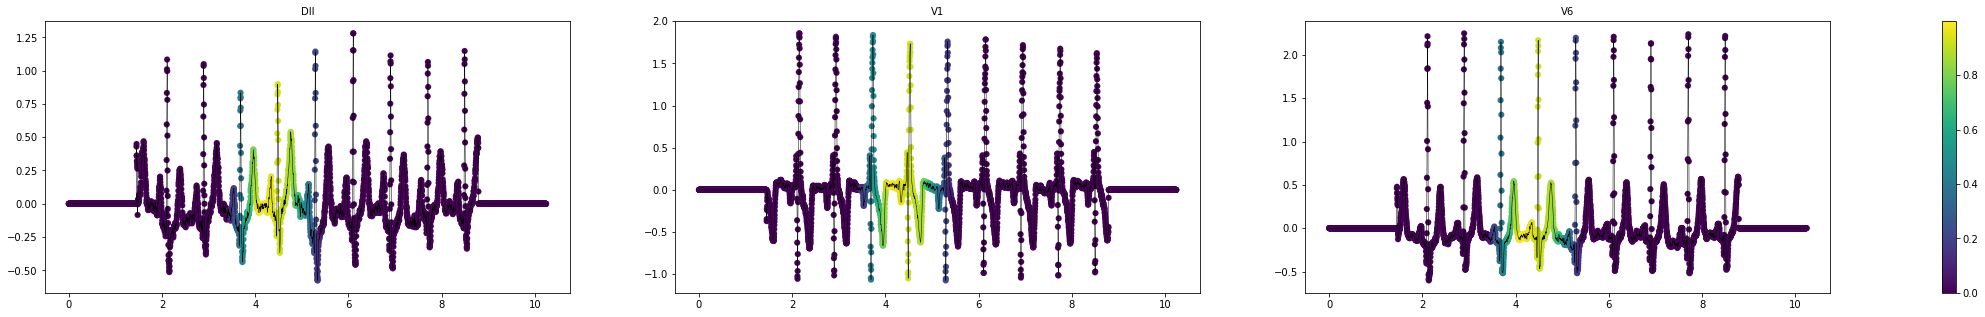

1dAVb             0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 255, dtype: int64
[0.02 0.74 0.   0.   0.   0.  ]


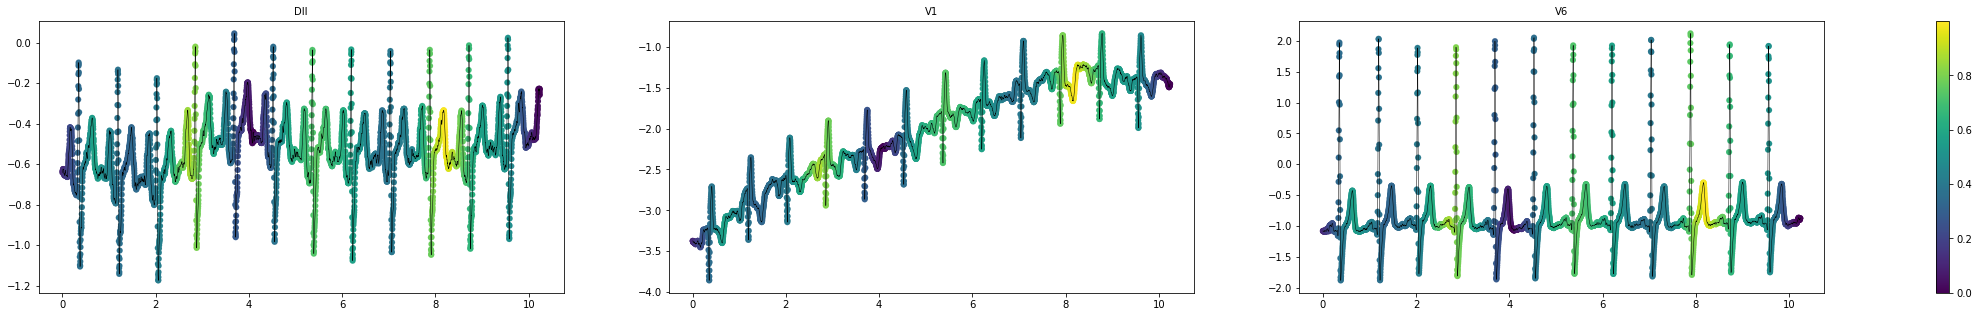



###########	 LBBB	###########

1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 1, dtype: int64
[0.03 0.   0.32 0.   0.05 0.  ]


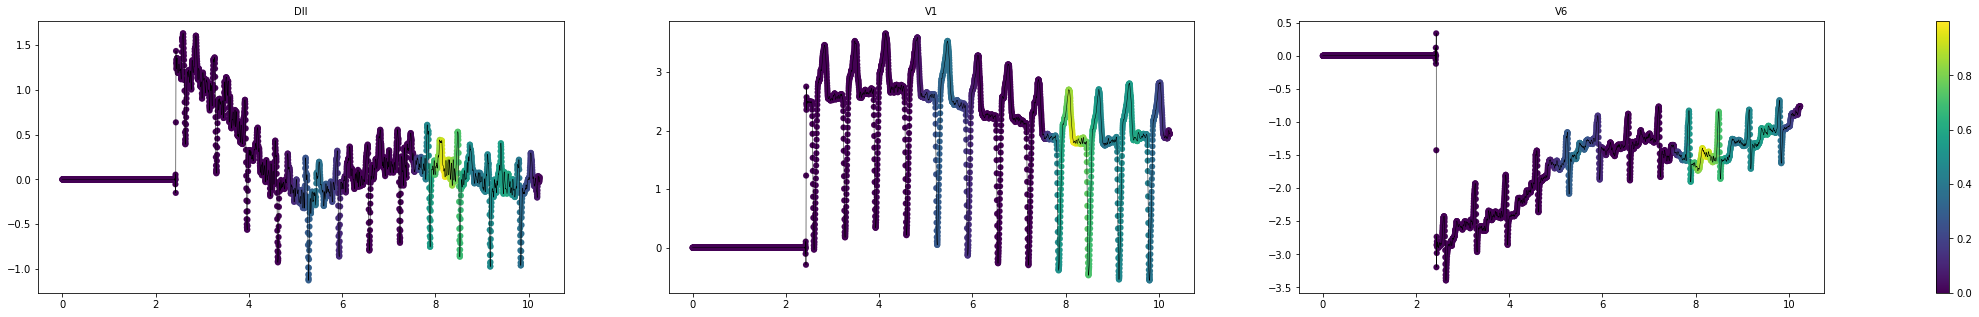

1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 28, dtype: int64
[0.01 0.   0.84 0.   0.01 0.  ]


1dAVb             0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 58, dtype: int64
[0.   0.   0.52 0.   0.   0.  ]




###########	 SB	###########

1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 40, dtype: int64
[0.   0.   0.   0.61 0.01 0.  ]


1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 75, dtype: int64
[0.01 0.01 0.   0.51 0.01 0.  ]


1dAVb             0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 98, dtype: int64
[0.   0.   0.   0.56 0.   0.  ]




###########	 AF	###########

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 120, dtype: int64
[0.   0.   0.   0.   0.94 0.  ]


1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 170, dtype: int64
[0.04 0.   0.   0.   0.21 0.  ]


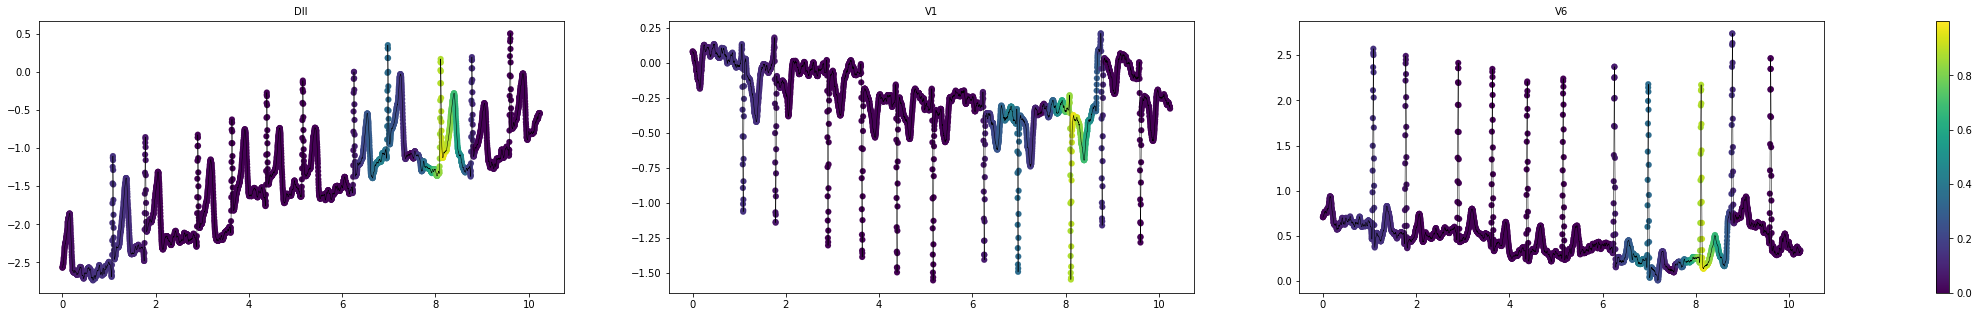

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 259, dtype: int64
[0.   0.   0.   0.   0.93 0.  ]


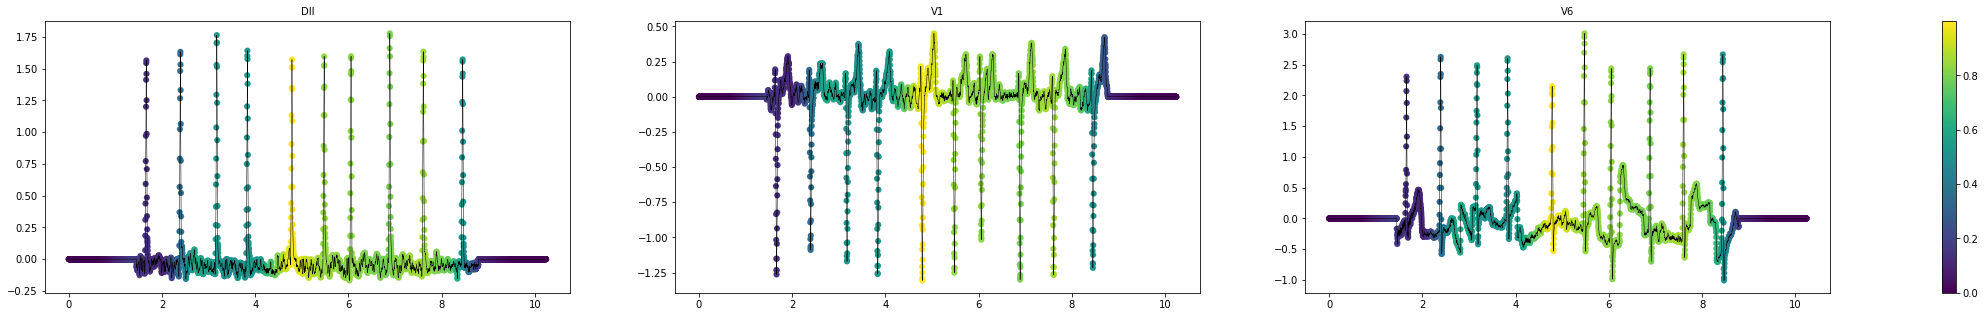



###########	 ST	###########

1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 23, dtype: int64
[0.   0.   0.   0.   0.05 0.38]


1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 33, dtype: int64
[0.   0.   0.   0.   0.   0.61]


1dAVb             0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 69, dtype: int64
[0.   0.   0.   0.   0.   0.61]


In [12]:
for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
  print(abnormality,idx_abn)

# visualisation a refaire en mieux
for idx_safe in df_goldStandard[df_goldStandard.nb_abnormality==0].index[:5]:
  fig, axs = plt.subplots(1, 3,figsize=(40,5))
  for i,pos in enumerate([1,6,11]):
    ax = axs[i]
    ax.set_title(lead_order[pos],fontsize=10)
    ax.plot(np.linspace(0,10.24,4096),x[idx_safe,:,pos],'k', linewidth=.5)
  plt.show()

for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
  index_abnormality = df_goldStandard[(df_goldStandard[abnormality]==1)&(df_goldStandard.nb_abnormality==1)].index
  print(f'\n\n###########\t {abnormality}\t###########\n')
  preds = model.predict(x[index_abnormality[:3]])
  for i, pos in enumerate(index_abnormality[:3]):
    np.set_printoptions(precision=2,suppress=True)
    print(df_goldStandard.iloc[pos])
    print(preds[i])
    plot_grad_cam_ecg(x[pos],check_y=idx_abn)
